In [1]:
# Third-party
import astropy.coordinates as coord
from astropy.table import Table, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData

from helpers import galcen_frame

In [3]:
g_l17 = GaiaData('../data/Li2017-Gaia-master.fits')
g_s14 = GaiaData('../data/Sheffield2014-Gaia-master.fits')

In [8]:
c_l17 = g_l17.get_skycoord(distance=g_l17.apw_distance * u.kpc,
                           radial_velocity=g_l17.rv*u.km/u.s)
c_s14 = g_s14.get_skycoord(distance=g_s14.apw_distance * u.kpc,
                           radial_velocity=g_s14.rv*u.km/u.s)

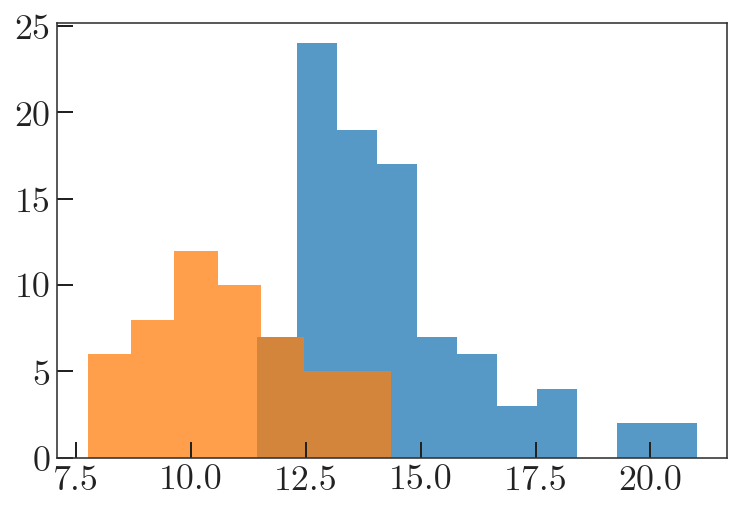

In [9]:
plt.figure(figsize=(6, 4))
plt.hist(c_s14.distance.kpc, bins='auto', alpha=0.75)
plt.hist(c_l17.distance.kpc, bins='auto', alpha=0.75);

In [80]:
c_ref_l17 = gc.reflex_correct(c_l17)
c_ref_s14 = gc.reflex_correct(c_s14)

gal_l17 = c_ref_l17.galactic
gal_s14 = c_ref_s14.galactic

galcen_l17 = c_l17.transform_to(galcen_frame)
galcen_s14 = c_s14.transform_to(galcen_frame)

galcen_samples = [c.transform_to(galcen_frame) for c in c_samples]
cyl_samples = [c.transform_to(galcen_frame) for c in c_samples]
for cyl in cyl_samples:
    cyl.set_representation_cls('cylindrical')

## Generate error samples

Conservative guess at RV error - see `Compile-data.ipynb`

In [71]:
rv_err = 8. * u.km/u.s # MAGIC NUMBER
n_samples = 1024

In [67]:
g = g_l17
c = c_l17

In [76]:
c_samples = [] 
for g, c in zip([g_l17, g_s14], [c_l17, c_s14]):
    Cov = g.get_cov()
    Cov[:, 5, 5] = rv_err.to_value(u.km/u.s) ** 2
    Cov[:, 2, :] = 0. # zero out parallax error
    Cov[:, :, 2] = 0. # zero out parallax error
    Cov[:, 2, 2] = (0.15 * c.distance.kpc) ** 2 # MAGIC NUMBER: 15% distance error

    mu = np.vstack((c.ra.degree, c.dec.degree, c.distance.kpc,
                    c.pm_ra_cosdec.to_value(u.mas/u.yr),
                    c.pm_dec.to_value(u.mas/u.yr),
                    c.radial_velocity.to_value(u.km/u.s))).T

    samples = np.stack([np.random.multivariate_normal(mu[i], Cov[i], size=n_samples)
                        for i in range(mu.shape[0])])
    _c_samples = coord.SkyCoord(ra=samples[..., 0]*u.deg,
                                dec=samples[..., 1]*u.deg,
                                distance=samples[..., 2]*u.kpc,
                                pm_ra_cosdec=samples[..., 3]*u.mas/u.yr,
                                pm_dec=samples[..., 4]*u.mas/u.yr,
                                radial_velocity=samples[..., 5]*u.km/u.s)
    c_samples.append(_c_samples)

(-295, -45)

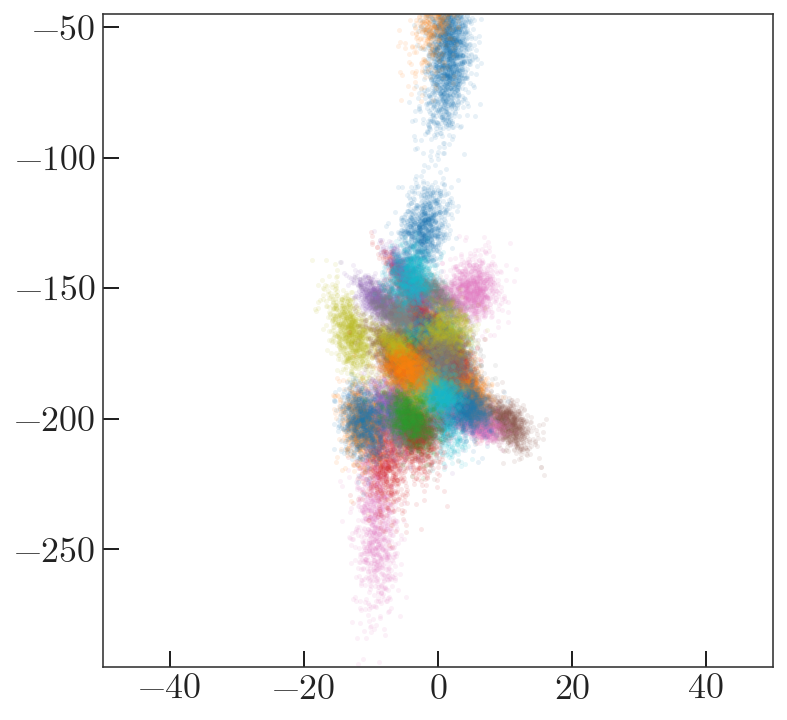

In [95]:
for i in range(cyl_samples[0].shape[0]):
    plt.plot(cyl_samples[1].d_rho[i],
             (cyl_samples[1].rho[i] * cyl_samples[1].d_phi[i]).to_value(u.km/u.s, u.dimensionless_angles()),
             marker='.', ls='none', alpha=0.1);
plt.xlim(-50, 50)
plt.ylim(-220-75, -220+175)

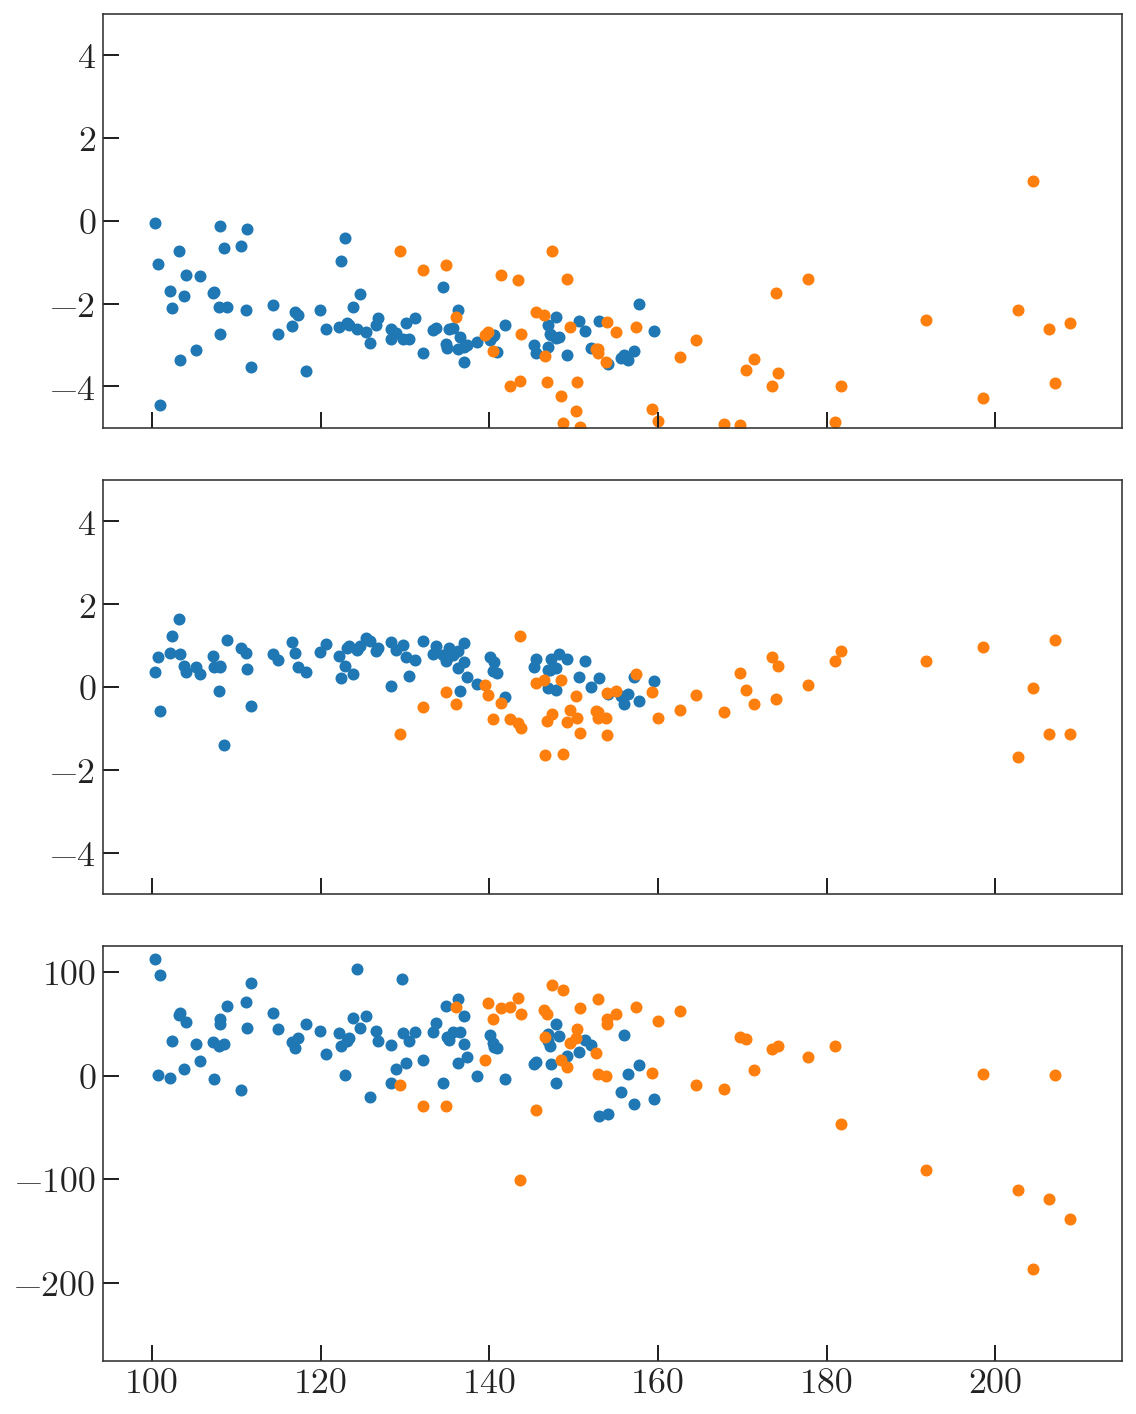

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10),
                         sharex=True)

for i, name in enumerate(['pm_l_cosb', 'pm_b', 'radial_velocity']):
    for gal in [gal_s14, gal_l17]:
        axes[i].scatter(gal.l.degree, 
                        getattr(gal, name).value)
        
axes[0].set_ylim(-5, 5)
axes[1].set_ylim(-5, 5)
axes[2].set_ylim(-275, 125)

fig.tight_layout()

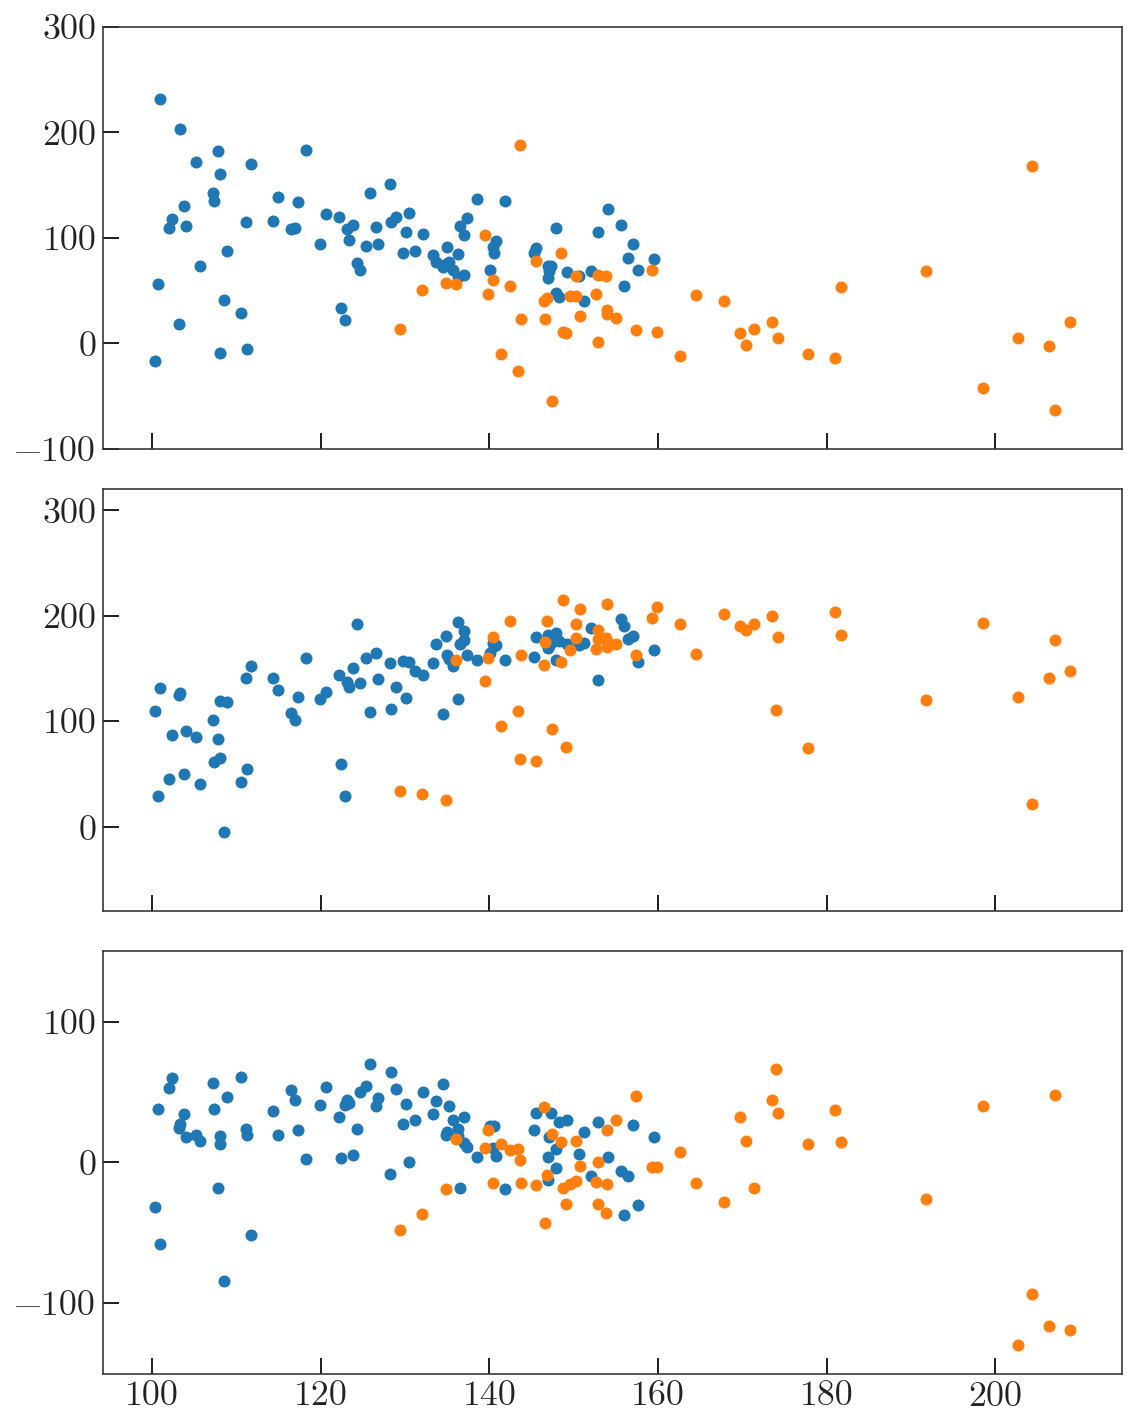

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10),
                         sharex=True)

for i, name in enumerate(['v_x', 'v_y', 'v_z']):
    for gal, galc in zip([gal_s14, gal_l17], 
                         [galcen_s14, galcen_l17]):
        axes[i].scatter(gal.l.degree, 
                        getattr(galc, name).value)
        
axes[0].set_ylim(-100, 300)
axes[1].set_ylim(-300 + 220, 100 + 220)
axes[2].set_ylim(-150, 150)

fig.tight_layout()

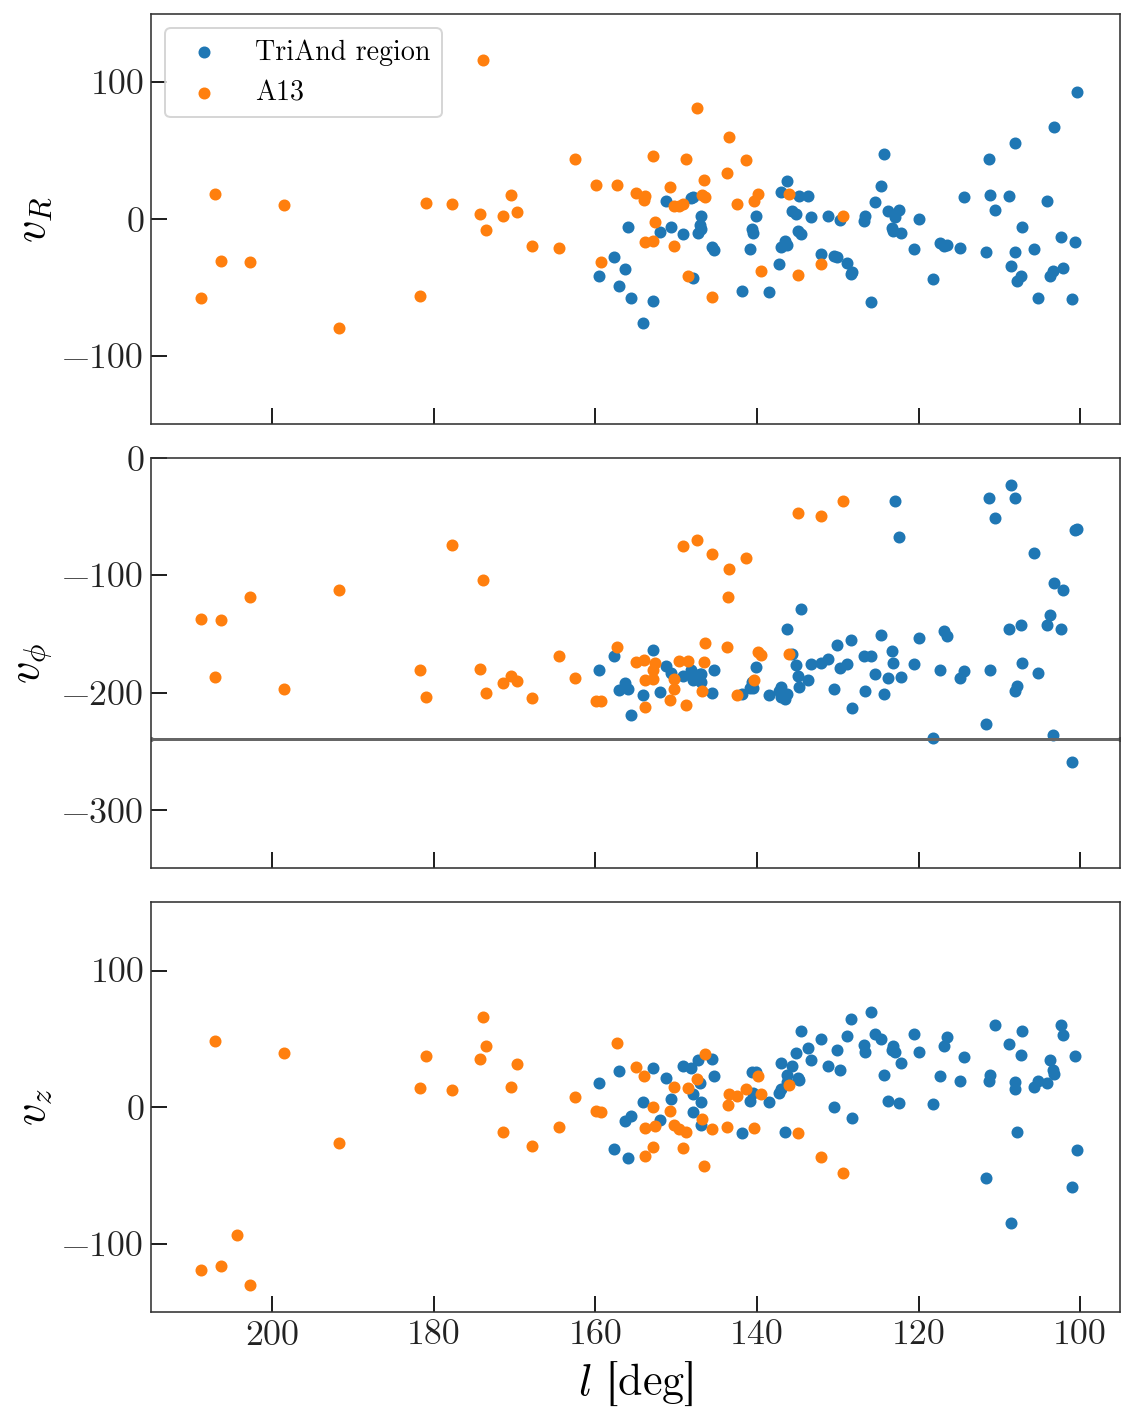

In [176]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10),
                         sharex=True)

for lbl, gal, galc in zip(['TriAnd region', 'A13'],
                          [gal_s14, gal_l17], 
                          [galcen_s14, galcen_l17]):
    cyl = galc.represent_as('cylindrical')
    vcyl = cyl.differentials['s']
    
    axes[0].scatter(gal.l.degree, 
                    vcyl.d_rho.to_value(u.km/u.s), 
                    label=lbl)
    axes[1].scatter(gal.l.degree, 
                    (cyl.rho * vcyl.d_phi).to_value(u.km/u.s, u.dimensionless_angles()))
    axes[2].scatter(gal.l.degree, 
                    vcyl.d_z.to_value(u.km/u.s))

axes[1].axhline(-240.)
    
axes[0].set_ylim(-150, 150)
axes[1].set_ylim(-350, 0)
axes[2].set_ylim(-150, 150)

axes[0].set_xlim(215, 95)

axes[0].set_ylabel('$v_R$')
axes[1].set_ylabel(r'$v_\phi$')
axes[2].set_ylabel('$v_z$')
axes[2].set_xlabel('$l$ [deg]')

axes[0].legend(loc='best', fontsize=14)

fig.tight_layout()

fig.savefig('../plots/cyl.png', dpi=250)

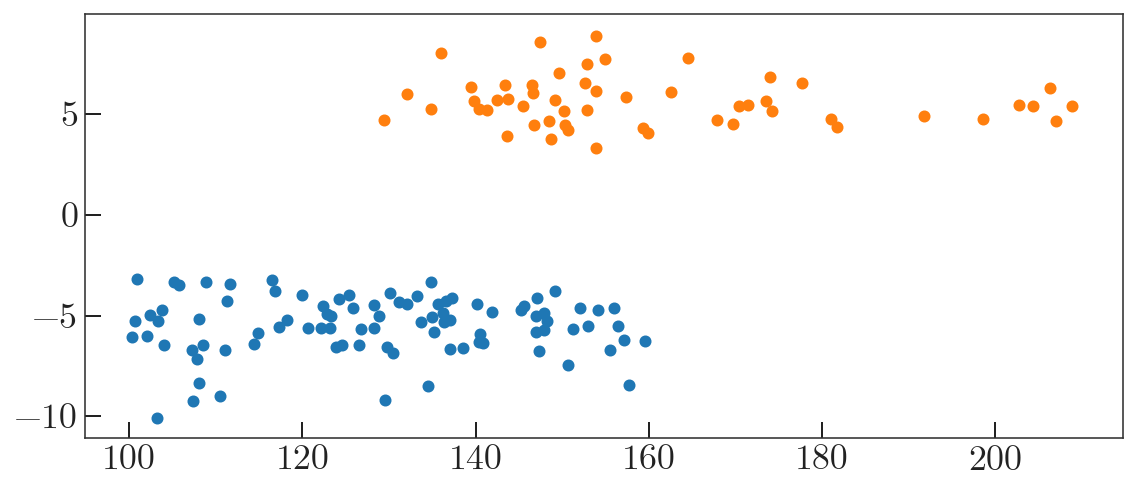

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5),
                         sharex=True)

for i, name in enumerate(['z']):
    for gal, galc in zip([gal_s14, gal_l17], 
                         [galcen_s14, galcen_l17]):
        ax.scatter(gal.l.degree, 
                   getattr(galc, name).value)
        
# axes[0].set_ylim(-100, 300)
# axes[1].set_ylim(-300 + 220, 100 + 220)
# axes[2].set_ylim(-150, 150)

fig.tight_layout()

---

In [11]:
test_mask = ((gal_s14.l < 140*u.deg) & (gal_s14.l > 120*u.deg) &
             (galcen_s14.v_z > 5*u.km/u.s) & (galcen_s14.v_z < 100*u.km/u.s) & 
             (galcen_s14.v_y > 100*u.km/u.s) & (galcen_s14.v_y < 180*u.km/u.s))

In [22]:
w0 = gd.PhaseSpacePosition(galcen_s14[test_mask].cartesian)
# w0 = gd.PhaseSpacePosition(galcen_s14.cartesian)

In [23]:
# mw = gp.MilkyWayPotential()
mw = gp.BovyMWPotential2014()

In [195]:
_orbits_back = mw.integrate_orbit(w0, dt=-0.5*u.Myr, n_steps=500)
orbits = mw.integrate_orbit(_orbits_back[-1], dt=0.5*u.Myr, n_steps=1000)

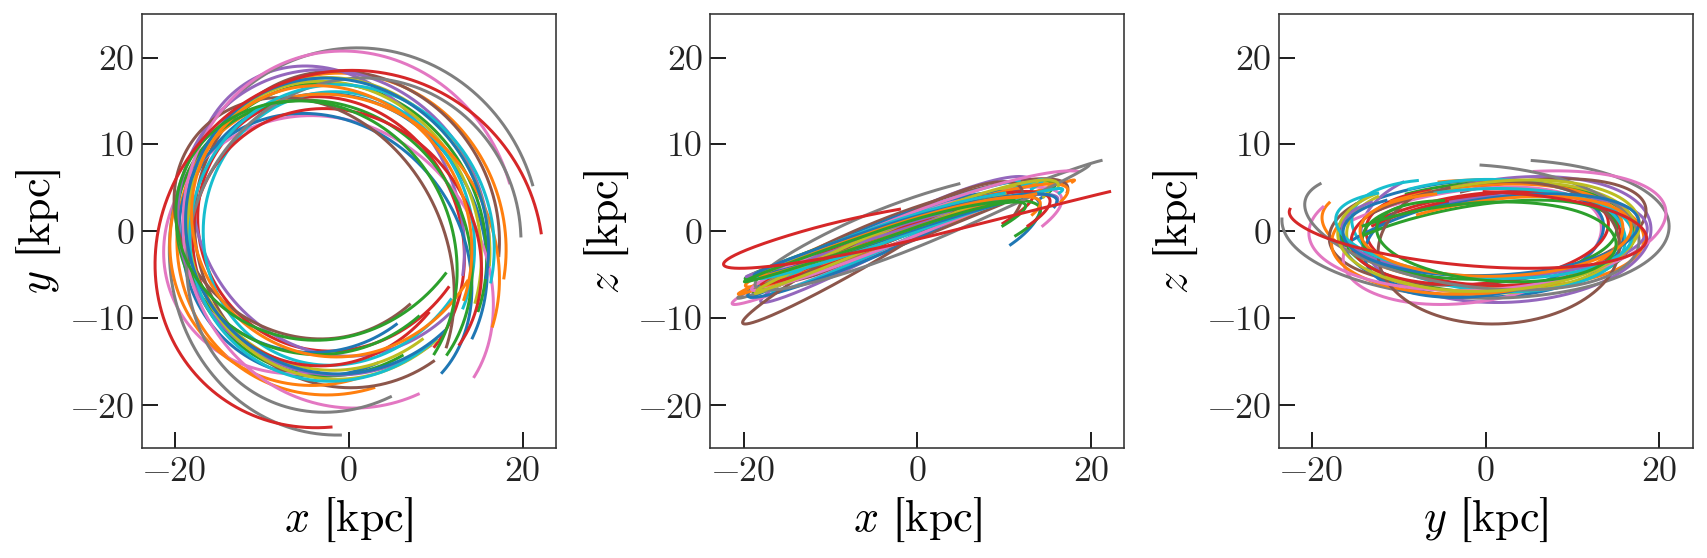

In [196]:
fig = orbits.plot()
# orbits_forw.plot(axes=fig.axes)
for ax in fig.axes:
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    
fig.savefig('../plots/orbits.png', dpi=250)

In [197]:
orbits_gal = orbits.to_coord_frame(coord.Galactic, 
                                   galactocentric_frame=galcen_frame)

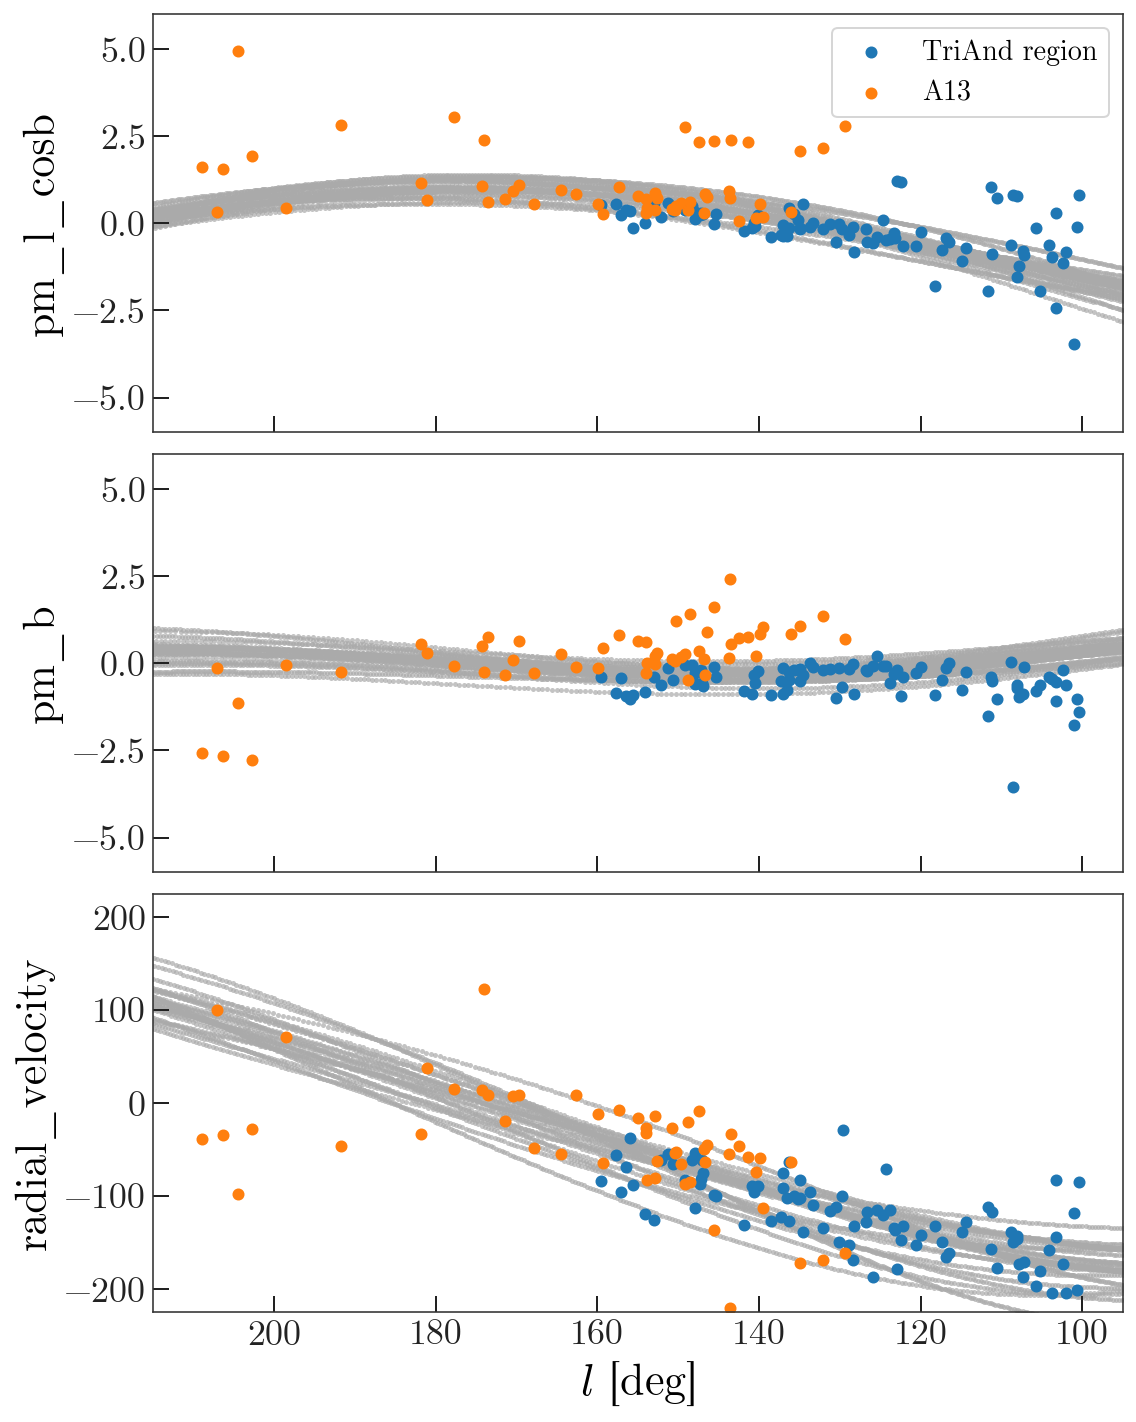

In [198]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10),
                         sharex=True)

for i, name in enumerate(['pm_l_cosb', 'pm_b', 'radial_velocity']):
    for lbl, gal, galc in zip(['TriAnd region', 'A13'],
                              [c_s14.galactic, c_l17.galactic], 
                              [galcen_s14, galcen_l17]):
        axes[i].scatter(gal.l.degree, 
                        getattr(gal, name).value,
                        label=lbl)
    
    axes[i].plot(orbits_gal.l.degree,
                 getattr(orbits_gal, name).value,
                 color='#aaaaaa', alpha=0.7, zorder=-100, marker='.', ls='none')
    
    axes[i].set_ylabel(name)
    
axes[0].legend(loc='best', fontsize=14)
    
axes[0].set_ylim(-6, 6)
axes[1].set_ylim(-6, 6)
axes[2].set_ylim(-225, 225)

axes[0].set_xlim(215, 95)
axes[2].set_xlabel('$l$ [deg]')

fig.tight_layout()
fig.savefig('../plots/obs_orbits.png', dpi=250)

---

In [207]:
from scipy.stats import binned_statistic
from scipy.ndimage import gaussian_filter1d

In [220]:
bins = np.linspace(60, 300, 256)
x = 0.5 * (stat.bin_edges[:-1] + stat.bin_edges[1:])

ys = [orbits_gal.b.degree,
      orbits_gal.distance.kpc,
      orbits_gal.pm_l_cosb.to_value(u.mas/u.yr),
      orbits_gal.pm_b.to_value(u.mas/u.yr),
      orbits_gal.radial_velocity.to_value(u.km/u.s)]

mean_tracks = [x]
std_tracks = [x]
for y in ys:
    stat = binned_statistic(orbits_gal.l.degree.ravel(), 
                            y.ravel(), 
                            bins=bins)
    _y = gaussian_filter1d(stat.statistic, sigma=2)
    mean_tracks.append(_y)
    
    stat = binned_statistic(orbits_gal.l.degree.ravel(), 
                            y.ravel(), 
                            bins=bins, statistic='std')
    _y = gaussian_filter1d(stat.statistic, sigma=2)
    std_tracks.append(_y)

mean_tracks = np.vstack(mean_tracks).T
std_tracks = np.vstack(std_tracks).T

np.save('../data/gal_mean_tracks.npy', mean_tracks)
np.save('../data/gal_std_tracks.npy', std_tracks)

/Users/adrian/anaconda/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


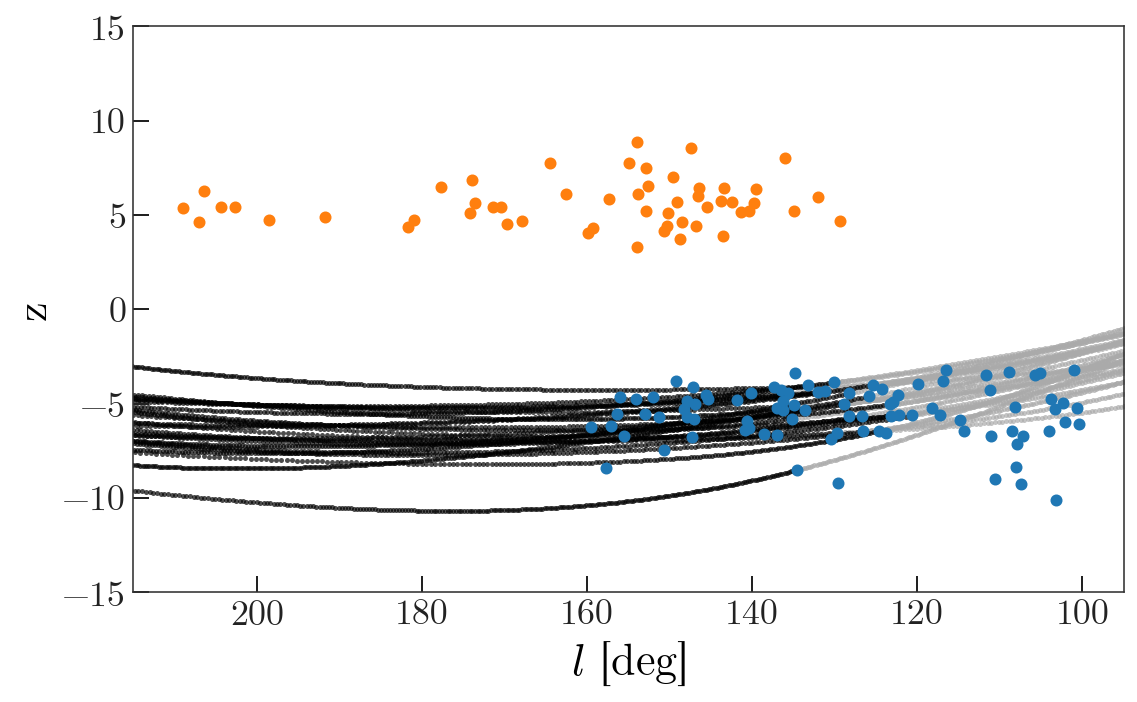

In [181]:
fig, axes = plt.subplots(1, 1, figsize=(8, 5),
                         sharex=True)
axes = [axes]

for i, name in enumerate(['z']):
    for gal, galc in zip([c_s14.galactic, c_l17.galactic], 
                         [galcen_s14, galcen_l17]):
        axes[i].scatter(gal.l.degree, 
                        getattr(galc, name).value)
    
    axes[i].plot(orbits_forw_gal.l.degree,
                 getattr(orbits_forw, name).value,
                 color='#aaaaaa', alpha=0.7, zorder=-100, marker='.', ls='none')
    axes[i].plot(orbits_back_gal.l.degree,
                 getattr(orbits_back, name).value,
                 color='k', alpha=0.7, zorder=-100, marker='.', ls='none')
    
    axes[i].set_ylabel(name)
    
axes[0].set_ylim(-15, 15)

axes[0].set_xlim(215, 95)
axes[0].set_xlabel('$l$ [deg]')

fig.tight_layout()

fig.savefig('../plots/obs_orbits_z.png', dpi=250)

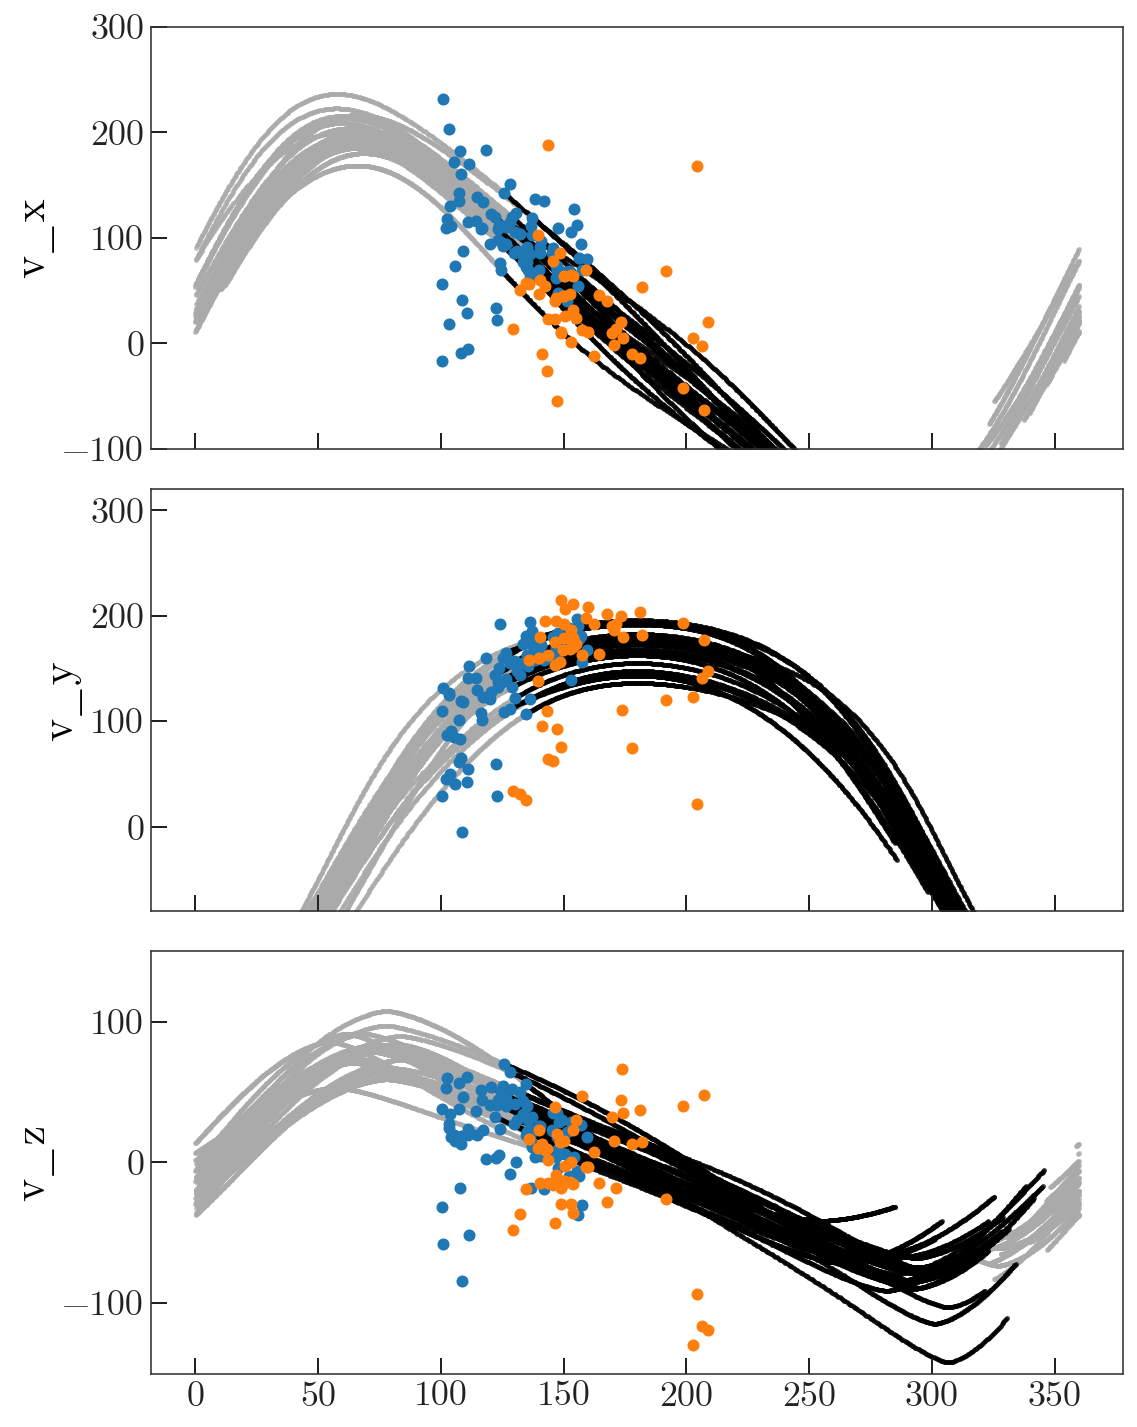

In [59]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10),
                         sharex=True)

for i, name in enumerate(['v_x', 'v_y', 'v_z']):
    for gal, galc in zip([gal_s14, gal_l17], 
                         [galcen_s14, galcen_l17]):
        axes[i].scatter(gal.l.degree, 
                        getattr(galc, name).value)
    
    axes[i].plot(orbits_forw_gal.l.degree,
                 getattr(orbits_forw, name).to_value(u.km/u.s),
                 color='#aaaaaa', alpha=0.7, zorder=-100, marker='.', ls='none')
    axes[i].plot(orbits_back_gal.l.degree,
                 getattr(orbits_back, name).to_value(u.km/u.s),
                 color='k', alpha=0.7, zorder=-100, marker='.', ls='none')
    
    axes[i].set_ylabel(name)
    
axes[0].set_ylim(-100, 300)
axes[1].set_ylim(-300 + 220, 100 + 220)
axes[2].set_ylim(-150, 150)

fig.tight_layout()

In [97]:
from matplotlib.patches import Ellipse

In [167]:
xx = np.array([5., 7.])
CC = np.array([[1.2, -0.99],
               [-0.99, 1.**2]])
derp = np.random.multivariate_normal(xx, CC, 1024)

In [168]:
def plot_ellipse(mu, Cov, nsigma=1, ax=None):
    vals, vecs = np.linalg.eig(Cov)
    alpha = np.degrees(np.arctan2(vecs[0][1], vecs[0][0]))
    
    ell = Ellipse(mu, 
                  nsigma*2*np.sqrt(vals[0]), 
                  nsigma*2*np.sqrt(vals[1]), 
                  angle=-alpha)
    
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.add_patch(ell)
    
    return ell

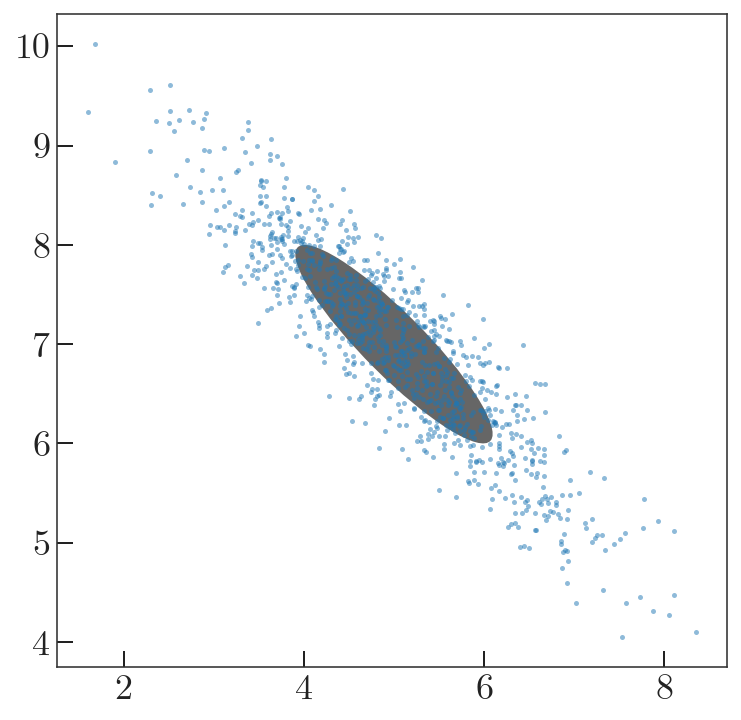

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(derp[:, 0], derp[:, 1], marker='.', alpha=0.5, ls='none')
ell = plot_ellipse(xx, CC, ax=ax)